# **ch.03 회귀 알고리즘과 모델 규제**
## 03-2 선형 회귀
### 풀어야 할 문제:
> ### k-nearest neighbors regressor로 예측한 50cm에 1.5kg인 perch의 prediction value가 실제와 매우 다름. test set의 range를 벗어난 sample에 대한 유효한 prediction을 수행하는 model 찾기
### *k-최근접 이웃의 한계*


문제 재현을 위해 data 준비

In [1]:
import numpy as np

perch_length = np.array([8.4, 13.7, 15.0, 16.2, 17.4, 18.0, 18.7, 19.0, 19.6, 20.0, 21.0,
       21.0, 21.0, 21.3, 22.0, 22.0, 22.0, 22.0, 22.0, 22.5, 22.5, 22.7,
       23.0, 23.5, 24.0, 24.0, 24.6, 25.0, 25.6, 26.5, 27.3, 27.5, 27.5,
       27.5, 28.0, 28.7, 30.0, 32.8, 34.5, 35.0, 36.5, 36.0, 37.0, 37.0,
       39.0, 39.0, 39.0, 40.0, 40.0, 40.0, 40.0, 42.0, 43.0, 43.0, 43.5,
       44.0])
perch_weight = np.array([5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0, 110.0,
       115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0, 130.0,
       150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0, 197.0,
       218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0, 514.0,
       556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0, 820.0,
       850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0, 1000.0,
       1000.0])

train set, test set 나누기

In [2]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(perch_length, perch_weight, random_state=42)

feature data(특성을 지닌 input data)를 2dim으로 변환

In [3]:
train_input = train_input.reshape(-1, 1)
test_input = test_input.reshape(-1, 1)

neighbor 수를 3으로 하는 k-nearest neighbors regressor를 만들고, train

In [4]:
from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor(n_neighbors=3)

knr.fit(train_input, train_target)

KNeighborsRegressor(n_neighbors=3)

length 50cm인 perch의 weight를 predict  
&rarr; 1.033kg으로 예측

In [5]:
knr.predict([[50]])

array([1033.33333333])

KNeighborsRegressor의 kneighbors() method로 50cm sample의 neighbors를 구하고, scatter를 그려 문제 파악

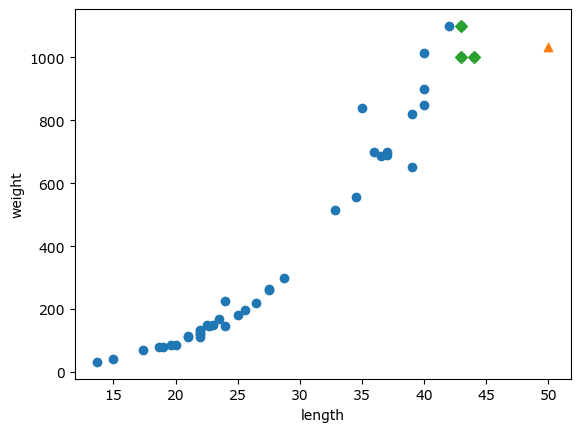

In [7]:
import matplotlib.pyplot as plt

distances, indexes = knr.kneighbors([[50]])

plt.scatter(train_input, train_target)
plt.scatter(50, 1033, marker='^')
plt.scatter(train_input[indexes], train_target[indexes], marker='D')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

50cm sample에서 가장 가까운 45cm 근방이기에 model은 해당 sample의 weight를 mean하여 predict함  
$\therefore$ predict value = 1.033kg


k-nearest neighbors regressor는 가장 가까운 sample을 찾아 해당 target을 평균하기 때문에 새로운 sample이 train set의 range를 벗어나면 엉뚱한 값을 predict할 수 있음  
&rarr; ex)100cm sample의 weight도 1.033kg으로 predict함

In [11]:
print(np.mean(train_target[indexes]))

1033.3333333333333


In [12]:
print(knr.predict([[100]]))

[1033.33333333]


### *선형 회귀*


linear regression:  
feature가 1개 일 때, 해당 feature를 가장 잘 나타내는 직선을 찾는 algorithm


scikit-learn의 LinearRegression import, class object 생성

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

train

In [14]:
lr.fit(train_input, train_target)

LinearRegression()

50cm predict  
&rarr; 1.242kg

In [15]:
lr.predict([[50]])

array([1241.83860323])

linear regression이 찾은 line의 기울기(gradient, coefficient, weight)와 절편값 확인

In [16]:
print(lr.coef_, lr.intercept_)

[39.01714496] -709.0186449535474


15cm에서 50cm까지 plot(linear regression이 찾은 line), train_set에 대한 scatter 그리기

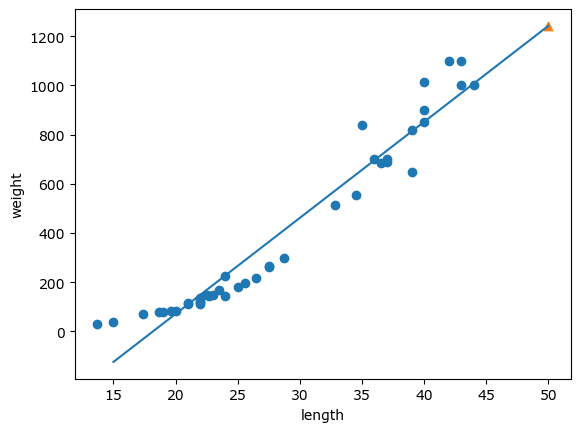

In [17]:
plt.plot([15, 50], [15*lr.coef_+lr.intercept_, 50*lr.coef_+lr.intercept_])

plt.scatter(train_input, train_target)
plt.scatter(50, 1241.8, marker='^')

plt.xlabel('length')
plt.ylabel('weight')
plt.show()

linear regression model의 train set과 test set에 대한 $R^2$ score 확인  
&rarr; underfitting(두 score가 전체적으로 낮음)

In [18]:
print(lr.score(train_input, train_target))
print(lr.score(test_input, test_target))

0.9398463339976041
0.824750312331356


### *다항 회귀*  
이 model은 underfitting 말고도 문제가 있음  
&rarr; 직선이 왼쪽 아래로 쭉 뻗어 있어 직선대로 predict하면 0g이하로 내려가는 상황도 발생함. 그러나 이는 현실에서 불가능


위 scatter를 살펴보면 직선이라기보다는 곡선에 가까움. 그렇다면 최적의 직선이 아닌 최적의 곡선을 찾으면 됨  
&rarr; 2차항이 필요함  
&rarr; column_stack() function을 사용하여 train_input을 제곱한 array를 train_input에 붙이기

In [19]:
train_poly = np.column_stack((train_input**2, train_input))
test_poly = np.column_stack((test_input**2, test_input))

In [21]:
print(train_input.shape, train_poly.shape)
print(test_input.shape, test_poly.shape)

(42, 1) (42, 2)
(14, 1) (14, 2)


train_poly를 사용해 linear regression model을 다시 train

In [22]:
lr = LinearRegression()

lr.fit(train_poly, train_target)

LinearRegression()

50cm sample의 weight predict  
&rarr; 1.574kg

In [23]:
lr.predict([[50**2, 50]])

array([1573.98423528])

위와 같은 equation을 polynomial이라 하며, polynomial을 사용한 linear regression을 polynomial regression(다항 회귀)이라 함


quadratic equation의 coefficient(gradient)와 intercept를 이용해 curve(짧은 line을 이어 그려 curve 표현), train set의 scatter 그리기

In [24]:
print(lr.coef_, lr.intercept_)

[  1.01433211 -21.55792498] 116.05021078278338


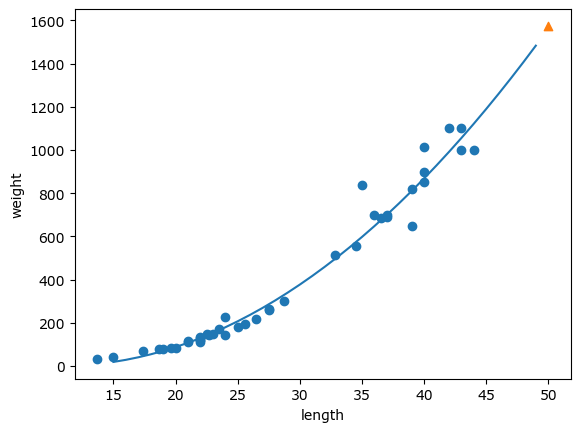

In [25]:
# interval별로 line을 그리기 위해 15~49의 integer array를 만들기
point = np.arange(15, 50)
plt.plot(point, 1.01*point**2 - 21.6*point + 116.06)

plt.scatter(train_input, train_target)
plt.scatter(50, 1574, marker='^')

plt.xlabel('length')
plt.ylabel('weight')
plt.show()

train set과 test set에 대한 $R^2$ score 확인  
&rarr; test score > train score 로 약간의 underfitting

In [27]:
print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))

0.9706807451768623
0.9775935108325122
